In [1]:
import torch
import torch.nn as nn
import pandas as pd
from project.dataset import Dataset, VALDODataset
from torch.utils.data import DataLoader
from project.preprocessing import NiftiToTensorTransform
from project.utils import collatev2
import winsound
from project.utils import compute_statistics
from project.evaluation import isa_rpn_metric, isa_vit_metric, Tracker

INFO:albumentations.check_version:A new version of Albumentations is available: 1.4.21 (you have 1.4.7). Upgrade using: pip install --upgrade albumentations


In [2]:
vit_tk = Tracker()
rpn_tk = Tracker()

### Update RPN Weights before running this notebook


In [3]:
rpn_weights = r'fold\Nov_23_2024_104831\fold_5\rpn_fold5.pt'

### Monitoring and CUDA Setup


In [4]:
import logging
from datetime import datetime as dtt
import os

path = 'logs'
os.makedirs(path, exist_ok=True)
os.makedirs('history', exist_ok=True)
rn = dtt.now()
dte = rn.strftime('%b_%d_%Y_%H%M%S')

logger = logging.getLogger('kess')
fh = logging.FileHandler(f'logs/rpn_vit_{dte}.log')
formatter = logging.Formatter(
    '%(asctime)s - %(levelname)s - %(message)s'
)

logger.setLevel(logging.DEBUG)
fh.setLevel(logging.DEBUG)
fh.setFormatter(formatter)

logger.addHandler(fh)

dte

'Nov_23_2024_153833'

In [5]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [6]:
vit_tk.date = rn
vit_tk.logfile = f'rpn_vit_{dte}.log'
vit_tk.device = device

### Config for RPN and ViT Fitter


In [7]:
from project.model import RPN, ISAVIT

rpn_config = {
    'model': RPN(
        input_dim=512,
        output_dim=4,
        image_size=300,
        global_context=True,
        nh=4,
        pretrained=False
    ).to(device),
}

324


C:\Program Files\Python310\lib\site-packages\torch\nn\modules\transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [8]:
vit_config = {
    'model': ISAVIT(
        d_model=512,
        patch_size=32,
        dim_ff=1600,
        global_context=True,
    ).to(device),
    'optimizer': torch.optim.Adam,
    'device': device,
    'epochs': 50,
    'loss': nn.BCEWithLogitsLoss(),
    'lr': 0.0001
}

In [9]:
vit_tk.model = 'ViT'
vit_tk.model_hyperparams = vit_config['model'].config
vit_tk.optimizer = f"{vit_config['optimizer']}"
vit_tk.epochs = vit_config['epochs']
vit_tk.loss = f"{vit_config['loss']}"
vit_tk.lr = vit_config['lr']

rpn_tk.model = 'RPN'
rpn_tk.model_hyperparams = rpn_config['model'].config

### Dataset Loading


In [10]:
data = pd.read_csv('targets.csv')
data.shape

(7986, 9)

In [11]:
data = data.query('has_microbleed_slice == 1').reset_index(drop=True)
vit_tk.only_cmb_slices = True
data

,mri,masks,stripped,target,has_microbleed_case,has_microbleed_slice,cohort,max_value,slices
0,C:\Users\araza\Documents\1\gits\thesis_project...,C:\Users\araza\Documents\1\gits\thesis_project...,C:\Users\araza\Documents\1\gits\thesis_project...,8,1,1,1,928.405273,35
1,C:\Users\araza\Documents\1\gits\thesis_project...,C:\Users\araza\Documents\1\gits\thesis_project...,C:\Users\araza\Documents\1\gits\thesis_project...,9,1,1,1,928.405273,35
2,C:\Users\araza\Documents\1\gits\thesis_project...,C:\Users\araza\Documents\1\gits\thesis_project...,C:\Users\araza\Documents\1\gits\thesis_project...,11,1,1,1,928.405273,35
3,C:\Users\araza\Documents\1\gits\thesis_project...,C:\Users\araza\Documents\1\gits\thesis_project...,C:\Users\araza\Documents\1\gits\thesis_project...,12,1,1,1,928.405273,35
4,C:\Users\araza\Documents\1\gits\thesis_project...,C:\Users\araza\Documents\1\gits\thesis_project...,C:\Users\araza\Documents\1\gits\thesis_project...,15,1,1,1,928.405273,35
...,...,...,...,...,...,...,...,...,...
359,C:\Users\araza\Documents\1\gits\thesis_project...,C:\Users\araza\Documents\1\gits\thesis_project...,C:\Users\araza\Documents\1\gits\thesis_project...,25,1,1,3,241.000000,36
360,C:\Users\araza\Documents\1\gits\thesis_project...,C:\Users\araza\Documents\1\gits\thesis_project...,C:\Users\araza\Documents\1\gits\thesis_project...,26,1,1,3,241.000000,36
361,C:\Users\araza\Documents\1\gits\thesis_project...,C:\Users\araza\Documents\1\gits\thesis_project...,C:\Users\araza\Documents\1\gits\thesis_project...,24,1,1,3,448.000000,39
362,C:\Users\araza\Documents\1\gits\thesis_project...,C:\Users\araza\Documents\1\gits\thesis_project...,C:\Users\araza\Documents\1\gits\thesis_project...,25,1,1,3,448.000000,39


### Preprocessing and Train-Test Split Function


In [12]:
from sklearn.model_selection import train_test_split

def make_loaders(data,
                 cohort,
                 test_size=0.2,
                 random_state=12,
                 target_shape=(300, 300),
                 rpn_mode=True,
                 logger=None,
                 vit_tracker=vit_tk
                ):
    if cohort == 1:
        vit_tracker.cohort1 = True
    if cohort == 2:
        vit_tracker.cohort2 = True
    if cohort == 3:
        vit_tracker.cohort3 = True
    
    vit_tracker.target_shape = target_shape
    data = data[data.cohort == cohort]
    
    s = f'Creating loaders for Cohort {cohort}\n'

    data_train, data_test = train_test_split(
        data,
        test_size=test_size,
        random_state=random_state
    )

    s += f'TRAIN & TEST: {data_train.shape, data_test.shape}\n'

    paths = data_train.stripped.unique().tolist()
    s += f'Total Unique MRI Samples in data_train: {len(paths)}\n'
    
    global_min, global_max = compute_statistics(paths)
    s += f'GLOBAL MIN & MAX {global_min, global_max}\n'

    transform = NiftiToTensorTransform(
        target_shape=target_shape,
        rpn_mode=rpn_mode,
        normalization=(global_min, global_max)
    )

    train_set = VALDODataset(
        cases=data_train.stripped.tolist(),
        masks=data_train.masks.tolist(),
        target=data_train.target.tolist(),
        transform=transform
    )
    val_set = VALDODataset(
        cases=data_test.stripped.tolist(),
        masks=data_test.masks.tolist(),
        target=data_test.target.tolist(),
        transform=transform
    )

    if logger != None:
        logger.info(s)
    else:
        print(s)
    
    return train_set, val_set

### ViT Fitter


In [13]:
from project import Fitter

class ViTFitter(Fitter):
    
    def fit(self, train_loader, val_loader, stage1):
        train_history = []
        val_history = []
        train_metric_history = []
        val_metric_history = []
        for epoch in range(self.epochs):
            self.log(f'EPOCH {epoch} ==============================')
            train_loss, train_metric = self.train_one_epoch(train_loader, stage1)
            val_loss, val_metric = self.validation(val_loader, stage1)
            train_history.append(train_loss)
            val_history.append(val_loss)
            train_metric_history.append(train_metric)
            val_metric_history.append(val_metric)
        return train_history, val_history, train_metric_history, val_metric_history

    def train_one_epoch(self, train_loader, stage1):
        self.model.train()
        loss_history = []
        evaluation_metric = {
            'dice_score': [], 
            'precision_score': [], 
            'recall_score': [], 
            'f1_score': [],
            'fpr': []
        }
        counter = 0
        for batch in train_loader:
            Y = []
            T = []
            for slices, masks, target, case in batch:
                slices = slices.squeeze(1).float().to(self.device)
                # slices = slices.squeeze(1).repeat(1, 3, 1, 1).float().to(self.device)
                masks = masks.float().to(self.device)

                with torch.inference_mode():
                    x, t = stage1(slices, masks, target)
                
                # self.log(f'{x.requires_grad}, {t.requires_grad}')
                # self.log(f'{x.shape}, {t.shape}')

                x = x.flatten(2).float().to(self.device)
                t = t.flatten(2).float().to(self.device)
                # self.log(f'XT SHAPES: {x.shape}, {t.shape}')
                
                y = self.model(x, target)
                
                # print('Prediction:', (y.sigmoid() >= 0.5).int().unique())
                # print('Truth:', (t[target] >= 0).int().unique())

                dice_score, precision_score, recall_score, f1_score, fpr = isa_vit_metric((y.sigmoid().squeeze().detach().cpu().numpy() >= 0.5), (t[target].squeeze().detach().cpu().numpy() > 0))

                evaluation_metric['dice_score'].append(dice_score)
                evaluation_metric['precision_score'].append(precision_score)
                evaluation_metric['recall_score'].append(recall_score)
                evaluation_metric['f1_score'].append(f1_score)
                evaluation_metric['fpr'].append(fpr)
                # self.log(f'EVAL METS: {dice_score, precision_score, recall_score, f1_score, fpr}')

                Y.append(y)
                T.append(t[target])
            
            losses = self.loss(torch.stack(Y), torch.stack(T))
            self.optimizer.zero_grad()
            losses.backward()
            self.optimizer.step()
            counter += 1
            self.log(f'Batch:\t{counter}/{len(train_loader)}')
            self.log(f'Batch samples:\t{len(batch)}')
            self.log(f'Current error:\t{losses}\n')
            
            loss_history.append(losses.detach().cpu().numpy())
        
        self.log(f'\nTraining Evaluation Metric:')
        self.log(f"Avg Dice: {sum(evaluation_metric['dice_score']) / len(evaluation_metric['dice_score'])}")
        self.log(f"Avg Precision: {sum(evaluation_metric['precision_score']) / len(evaluation_metric['precision_score'])}")
        self.log(f"Avg Recall: {sum(evaluation_metric['recall_score']) / len(evaluation_metric['recall_score'])}")
        self.log(f"Avg F1: {sum(evaluation_metric['f1_score']) / len(evaluation_metric['f1_score'])}")
        self.log(f"Avg FPR: {sum(evaluation_metric['fpr']) / len(evaluation_metric['fpr'])}\n")
        return loss_history, evaluation_metric
    
    def validation(self, val_loader, stage1):
        self.model.eval()
        loss_history = []
        evaluation_metric = {
            'dice_score': [], 
            'precision_score': [], 
            'recall_score': [], 
            'f1_score': [],
            'fpr': []
        }
        with torch.inference_mode():
            for batch in val_loader:
                Y = []
                T = []
                for slices, masks, target, case in batch:
                    slices = slices.squeeze(1).float().to(self.device)
                    # slices = slices.squeeze(1).repeat(1, 3, 1, 1).float().to(self.device)
                    masks = masks.float().to(self.device)
                    x, t = stage1(slices, masks, target)
                    x = x.flatten(2).float().to(self.device)
                    t = t.flatten(2).float().to(self.device)
                    y = self.model(x, target)

                    dice_score, precision_score, recall_score, f1_score, fpr = isa_vit_metric((y.sigmoid().squeeze().detach().cpu().numpy() >= 0.5), (t[target].squeeze().detach().cpu().numpy() > 0))
                    evaluation_metric['dice_score'].append(dice_score)
                    evaluation_metric['precision_score'].append(precision_score)
                    evaluation_metric['recall_score'].append(recall_score)
                    evaluation_metric['f1_score'].append(f1_score)
                    evaluation_metric['fpr'].append(fpr)
                    Y.append(y)
                    T.append(t[target])
                
                losses = self.loss(torch.stack(Y), torch.stack(T))
                loss_history.append(losses.cpu().numpy())
        
        self.log(f'\nValidations Evaluation Metric:')
        self.log(f"Avg Dice: {sum(evaluation_metric['dice_score']) / len(evaluation_metric['dice_score'])}")
        self.log(f"Avg Precision: {sum(evaluation_metric['precision_score']) / len(evaluation_metric['precision_score'])}")
        self.log(f"Avg Recall: {sum(evaluation_metric['recall_score']) / len(evaluation_metric['recall_score'])}")
        self.log(f"Avg F1: {sum(evaluation_metric['f1_score']) / len(evaluation_metric['f1_score'])}")
        self.log(f"Avg FPR: {sum(evaluation_metric['fpr']) / len(evaluation_metric['fpr'])}\n")
        return loss_history, evaluation_metric

### Train-Test Split


In [14]:
vit_t1, vit_v1 = make_loaders(
    data=data,
    cohort=1,
    rpn_mode=False
)

vit_t3, vit_v3 = make_loaders(
    data=data,
    cohort=3,
    rpn_mode=False
)

Creating loaders for Cohort 1
TRAIN & TEST: ((36, 9), (9, 9))
Total Unique MRI Samples in data_train: 8
GLOBAL MIN & MAX (0.0, 1417.92822265625)

Creating loaders for Cohort 3
TRAIN & TEST: ((37, 9), (10, 9))
Total Unique MRI Samples in data_train: 26
GLOBAL MIN & MAX (0.0, 573.0)



In [15]:
from torch.utils.data import ConcatDataset

vit_train_set = ConcatDataset([vit_t1, vit_t3])
vit_test_set = ConcatDataset([vit_v1, vit_v3])

print(f'ViT Train Set Size: {vit_train_set}')
print(f'ViT Test Set Size: {vit_test_set}')

ViT Train Set Size: <torch.utils.data.dataset.ConcatDataset object at 0x000001B56E788B80>
ViT Test Set Size: <torch.utils.data.dataset.ConcatDataset object at 0x000001B56E789510>


In [16]:
batchs = 15

vit_test_dataloader = DataLoader(
    vit_test_set,
    shuffle=True,
    batch_size=batchs,
    collate_fn=collatev2
)

### K-Fold Cross Validation


In [17]:
from torch.utils.data import Subset
from sklearn.model_selection import KFold

In [18]:
kf = KFold(n_splits=5, shuffle=True, random_state=45)
kf

KFold(n_splits=5, random_state=45, shuffle=True)

In [19]:
from project.model import Feeder, GCRPN
from project.preprocessing import NiftiToTensorTransform, get_transform

image_size = 300
patch_size = 32

In [20]:
vit_test_dice = []
vit_test_precision = []
vit_test_recall = []
vit_test_f1 = []
vit_test_fpr = []

In [21]:
vit_fold_metrics = []


fold_dir = f'./fold/{dte}'
os.makedirs(fold_dir, exist_ok=True)

for i, (train_index, val_index) in enumerate(kf.split(vit_train_set)):
    print(f'Fold {i + 1}/{5}')
    logger.info(f'################################### Fold {i+1}/5 ###################################')
    
    # RPN
    # rpn_config['model'] = RPN(**rpn_tk.model_hyperparams).to(device)
    rpn = RPN(**rpn_tk.model_hyperparams).to(device)
    rpn.load_state_dict(torch.load(rpn_weights))
    vit_tk.stage1_weights = rpn_weights

    # FEEDER
    
    resize = get_transform(
        height=patch_size,
        width=patch_size,
        p=1.0,
        rpn_mode=False
    )

    feeder = Feeder(resize)
    stone = GCRPN(
        rpn=rpn,
        feeder=feeder,
        image_size=image_size,
        patch_size=patch_size
    ).to(device)
    
    # ViT
    
    vit_config['model'] = ISAVIT(**vit_tk.model_hyperparams).to(device)
    
    vit_fitter = ViTFitter(vit_config, logger=logger)
    
    train_subset = Subset(vit_train_set, train_index)
    val_subset = Subset(vit_train_set, val_index)

    vit_tk.batch_size = 15
    
    train_subset_dl = DataLoader(
        train_subset,
        shuffle=True,
        batch_size=vit_tk.batch_size,
        collate_fn=collatev2
    )
    
    val_subset_dl = DataLoader(
        val_subset,
        shuffle=True,
        batch_size=vit_tk.batch_size,
        collate_fn=collatev2
    )
    
    vit_thist, vit_vhist, vit_tmhist, vit_vmhist = vit_fitter.fit(train_subset_dl, val_subset_dl, stone)
    
    vit_fold_metrics.append({
        'fold': i + 1,
        'training_history': vit_thist,
        'validation_history': vit_vhist,
        'training_metrics': vit_tmhist,
        'validation_metrics': vit_vmhist
    })
    
    vit_h, vit_mh = vit_fitter.validation(vit_test_dataloader, stone)
    vit_valmets = pd.DataFrame(vit_mh)
    vit_mets = vit_valmets.mean()
    
    vit_test_dice.append(vit_mets.dice_score)
    vit_test_precision.append(vit_mets.precision_score)
    vit_test_recall.append(vit_mets.recall_score)
    vit_test_f1.append(vit_mets.f1_score)
    vit_test_fpr.append(vit_mets.fpr)

    os.makedirs(f'{fold_dir}/fold_{i+1}', exist_ok=True)
    torch.save(vit_fitter.model.state_dict(), f'{fold_dir}/fold_{i+1}/vit_fold{i+1}.pt')

    

INFO:kess:################################### Fold 1/5 ###################################


Fold 1/5
324


C:\Program Files\Python310\lib\site-packages\torch\nn\modules\transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
INFO:kess:EPOCH 0 ==============================
C:\Program Files\Python310\lib\site-packages\torch\nn\modules\conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ..\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,
C:\Program Files\Python310\lib\site-packages\torch\nn\functional.py:5504: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at ..\aten\src\ATen\native\transformers\cud

Fold 2/5
324


INFO:kess:EPOCH 0 ==============================
INFO:kess:Batch:	1/4
INFO:kess:Batch samples:	15
INFO:kess:Current error:	0.7376486659049988

INFO:kess:Batch:	2/4
INFO:kess:Batch samples:	15
INFO:kess:Current error:	0.7112585306167603

INFO:kess:Batch:	3/4
INFO:kess:Batch samples:	15
INFO:kess:Current error:	0.6875687837600708

INFO:kess:Batch:	4/4
INFO:kess:Batch samples:	13
INFO:kess:Current error:	0.6665005683898926

INFO:kess:
Training Evaluation Metric:
INFO:kess:Avg Dice: 0.002304914786646219
INFO:kess:Avg Precision: 0.001161563280646946
INFO:kess:Avg Recall: 0.3206896551724138
INFO:kess:Avg F1: 0.002304914786646219
INFO:kess:Avg FPR: 0.3132304849416561

INFO:kess:
Validations Evaluation Metric:
INFO:kess:Avg Dice: 0.0014386051157229474
INFO:kess:Avg Precision: 0.0007247952899261567
INFO:kess:Avg Recall: 0.13333333333333333
INFO:kess:Avg F1: 0.0014386051157229474
INFO:kess:Avg FPR: 0.26392625950684195

INFO:kess:EPOCH 1 ==============================
INFO:kess:Batch:	1/4
INFO:ke

Fold 3/5
324


INFO:kess:EPOCH 0 ==============================
INFO:kess:Batch:	1/4
INFO:kess:Batch samples:	15
INFO:kess:Current error:	0.7286462187767029

INFO:kess:Batch:	2/4
INFO:kess:Batch samples:	15
INFO:kess:Current error:	0.704047441482544

INFO:kess:Batch:	3/4
INFO:kess:Batch samples:	15
INFO:kess:Current error:	0.6842535734176636

INFO:kess:Batch:	4/4
INFO:kess:Batch samples:	13
INFO:kess:Current error:	0.6562753319740295

INFO:kess:
Training Evaluation Metric:
INFO:kess:Avg Dice: 0.002005869648499444
INFO:kess:Avg Precision: 0.0010110589392758414
INFO:kess:Avg Recall: 0.2242200328407225
INFO:kess:Avg F1: 0.0020058696484994447
INFO:kess:Avg FPR: 0.3071602566563175

INFO:kess:
Validations Evaluation Metric:
INFO:kess:Avg Dice: 0.0036487445046509003
INFO:kess:Avg Precision: 0.001852335408319635
INFO:kess:Avg Recall: 0.2
INFO:kess:Avg F1: 0.0036487445046509003
INFO:kess:Avg FPR: 0.25902780652697843

INFO:kess:EPOCH 1 ==============================
INFO:kess:Batch:	1/4
INFO:kess:Batch samples

Fold 4/5
324


INFO:kess:EPOCH 0 ==============================
INFO:kess:Batch:	1/4
INFO:kess:Batch samples:	15
INFO:kess:Current error:	0.7282090187072754

INFO:kess:Batch:	2/4
INFO:kess:Batch samples:	15
INFO:kess:Current error:	0.6959378719329834

INFO:kess:Batch:	3/4
INFO:kess:Batch samples:	15
INFO:kess:Current error:	0.6782160997390747

INFO:kess:Batch:	4/4
INFO:kess:Batch samples:	14
INFO:kess:Current error:	0.6549338102340698

INFO:kess:
Training Evaluation Metric:
INFO:kess:Avg Dice: 0.0019356647115780726
INFO:kess:Avg Precision: 0.0009763478662789109
INFO:kess:Avg Recall: 0.256869542886492
INFO:kess:Avg F1: 0.0019356647115780729
INFO:kess:Avg FPR: 0.30554319863919277

INFO:kess:
Validations Evaluation Metric:
INFO:kess:Avg Dice: 0.00273874698117805
INFO:kess:Avg Precision: 0.0013741741503155637
INFO:kess:Avg Recall: 0.42857142857142855
INFO:kess:Avg F1: 0.00273874698117805
INFO:kess:Avg FPR: 0.26602649060886724

INFO:kess:EPOCH 1 ==============================
INFO:kess:Batch:	1/4
INFO:kes

Fold 5/5
324


INFO:kess:EPOCH 0 ==============================
INFO:kess:Batch:	1/4
INFO:kess:Batch samples:	15
INFO:kess:Current error:	0.7219780087471008

INFO:kess:Batch:	2/4
INFO:kess:Batch samples:	15
INFO:kess:Current error:	0.7006593346595764

INFO:kess:Batch:	3/4
INFO:kess:Batch samples:	15
INFO:kess:Current error:	0.6748011112213135

INFO:kess:Batch:	4/4
INFO:kess:Batch samples:	14
INFO:kess:Current error:	0.6509180068969727

INFO:kess:
Training Evaluation Metric:
INFO:kess:Avg Dice: 0.002364625248365358
INFO:kess:Avg Precision: 0.001191079262161763
INFO:kess:Avg Recall: 0.30329566854990586
INFO:kess:Avg F1: 0.002364625248365358
INFO:kess:Avg FPR: 0.30066072635161045

INFO:kess:
Validations Evaluation Metric:
INFO:kess:Avg Dice: 0.0024056007723486862
INFO:kess:Avg Precision: 0.0012112628641450156
INFO:kess:Avg Recall: 0.20238095238095238
INFO:kess:Avg F1: 0.0024056007723486867
INFO:kess:Avg FPR: 0.25169469116107657

INFO:kess:EPOCH 1 ==============================
INFO:kess:Batch:	1/4
INFO:

In [22]:
import winsound

winsound.Beep(500, 500)
winsound.Beep(500, 500)
winsound.Beep(500, 500)

### Metrics Visualization


In [23]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [24]:
def plot_metric_history(fold_metrics, metric, title=None):
    avg_train = []
    avg_test = []

    for fold in range(len(fold_metrics)):
        train = []
        test = []
        
        for epoch in range(len(fold_metrics[fold]['training_metrics'])):
            th = np.array(fold_metrics[fold]['training_metrics'][epoch][metric]).mean()
            train.append(th)
            vh = np.array(fold_metrics[fold]['validation_metrics'][epoch][metric]).mean()
            test.append(vh)
            
        avg_train.append(np.array(train))
        avg_test.append(np.array(test))
    
    epochs = len(np.mean(avg_train, axis=0)) + 1
            
    sns.lineplot(x=range(1, epochs), y=np.mean(avg_train, axis=0), label=f'Training {metric}')
    sns.lineplot(x=range(1, epochs), y=np.mean(avg_test, axis=0), label=f'Validation {metric}')
    
    plt.title(f'{title} - Training and Validation {metric}')
    plt.xlabel('Epoch')
    plt.ylabel(metric)
    plt.legend()
        
    plt.tight_layout()  
    plt.show()

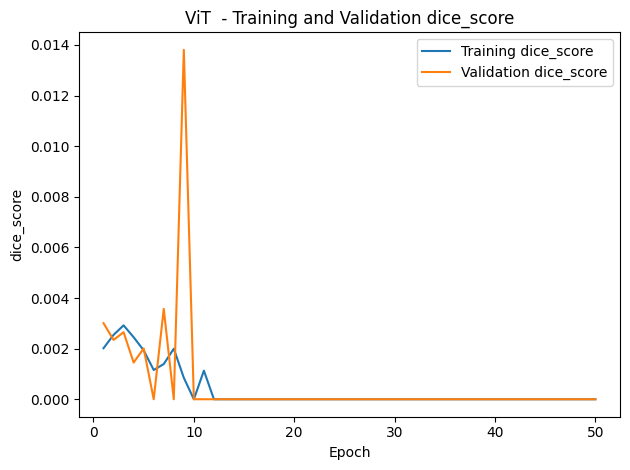

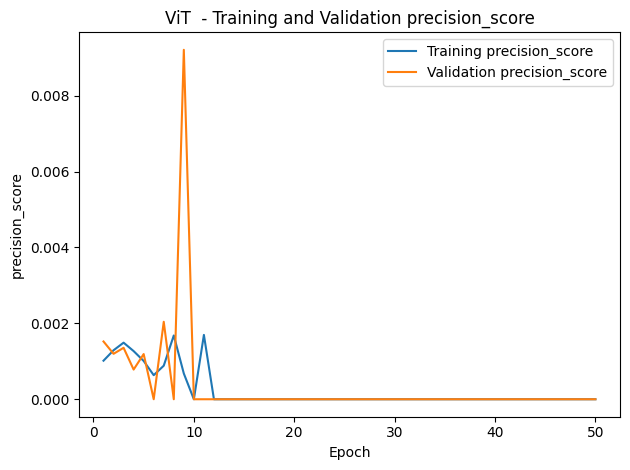

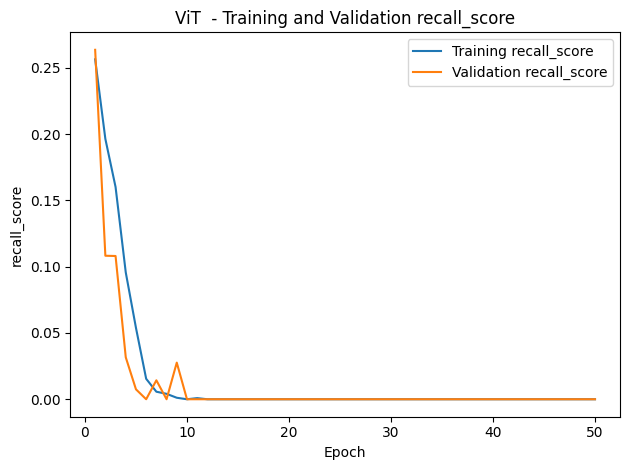

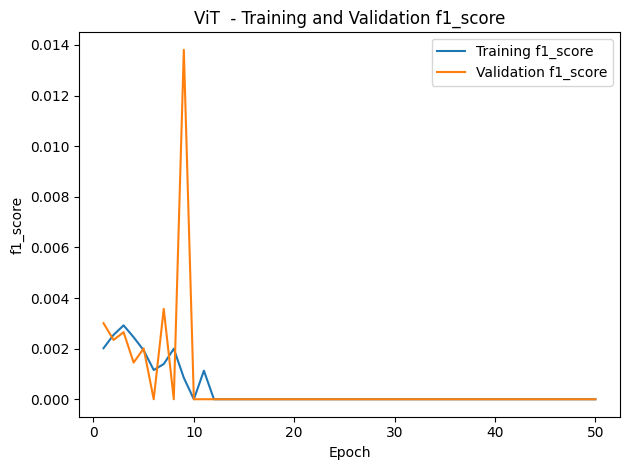

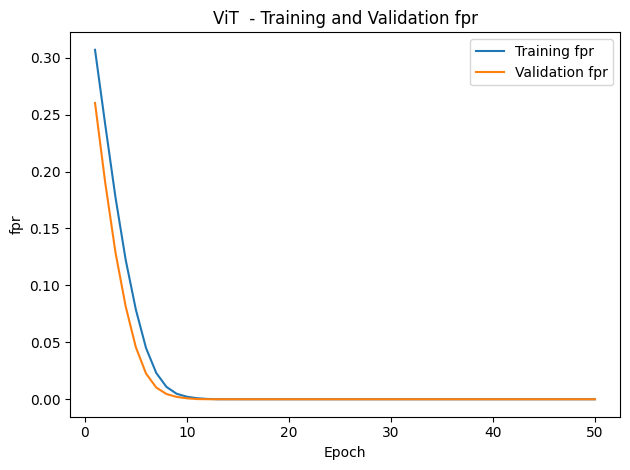

In [25]:
vit_metrics = ['dice_score', 'precision_score', 'recall_score', 'f1_score', 'fpr']

for metric in vit_metrics:
    plot_metric_history(vit_fold_metrics, metric, 'ViT ')

### Loss History Visualization


In [26]:
def plot_loss_history(fold_metrics, title=None):
    avg_train = []
    avg_test = []

    for fold in range(len(fold_metrics)):
        train = []
        test = []
        
        for epoch in range(len(fold_metrics[fold]['training_history'])):
            th = np.array(fold_metrics[fold]['training_history'][epoch]).mean()
            train.append(th)
            vh = np.array(fold_metrics[fold]['validation_history'][epoch]).mean()
            test.append(vh)
            
        avg_train.append(np.array(train))
        avg_test.append(np.array(test))
    
    epochs = len(np.mean(avg_train, axis=0)) + 1
        
    sns.lineplot(x=range(1, epochs), y=np.mean(avg_train, axis=0), label='Training history')
    sns.lineplot(x=range(1, epochs), y=np.mean(avg_test, axis=0), label='Validation history')
        
    plt.title(f'{title} - Training and Validation history')
    plt.xlabel('Epoch')
    plt.ylabel(metric)
    plt.legend()
    
    plt.tight_layout()  
    plt.show()

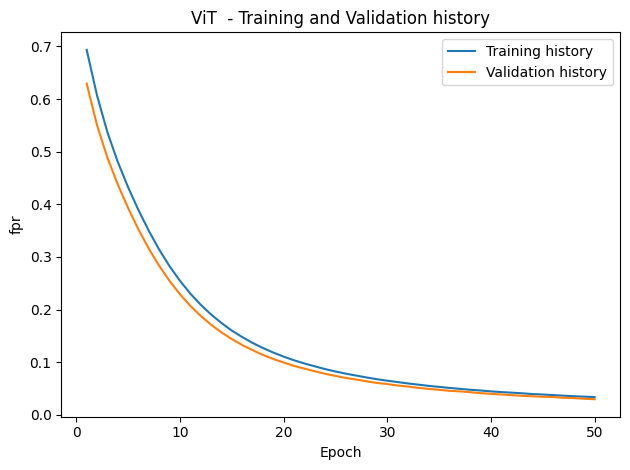

In [27]:
plot_loss_history(vit_fold_metrics, 'ViT ')

### Evaluate Test Set


#### ViT


In [28]:
df_vit_metrics = pd.DataFrame(columns=['fold', 'dice', 'precision', 'recall', 'f1', 'fpr'])
df_vit_metrics

,fold,dice,precision,recall,f1,fpr


In [29]:
df_vit_metrics['fold'] = [1, 2, 3, 4, 5]
df_vit_metrics['dice'] = vit_test_dice
df_vit_metrics['precision'] = vit_test_precision
df_vit_metrics['recall'] = vit_test_recall
df_vit_metrics['f1'] = vit_test_f1
df_vit_metrics['fpr'] = vit_test_fpr

In [30]:
vit_tk.dice = df_vit_metrics.dice
vit_tk.precision = df_vit_metrics.precision
vit_tk.recall = df_vit_metrics.recall
vit_tk.f1 = df_vit_metrics.f1
vit_tk.fpr = df_vit_metrics.fpr

In [31]:
df_vit_metrics

,fold,dice,precision,recall,f1,fpr
0,1,0.0,0.0,0.0,0.0,0.0
1,2,0.0,0.0,0.0,0.0,0.0
2,3,0.0,0.0,0.0,0.0,0.0
3,4,0.0,0.0,0.0,0.0,0.0
4,5,0.0,0.0,0.0,0.0,0.0


In [32]:
# vit_iou_score = np.array(vit_test_iou).mean()
vit_dice_score = np.array(vit_test_dice).mean()
vit_precision_score = np.array(vit_test_precision).mean()
vit_recall_score = np.array(vit_test_recall).mean()
vit_f1_score = np.array(vit_test_f1).mean()
vit_fpr_score = np.array(vit_test_fpr).mean()

print('ViT Test Set Performance Metrics')
print(f'Average Dice Score: {vit_dice_score} ')
print(f'Average Precision: {vit_precision_score} ')
print(f'Average Recall: {vit_recall_score} ')
print(f'Average F1 Score: {vit_f1_score} ')
print(f'Average FPR: {vit_fpr_score} ')

ViT Test Set Performance Metrics
Average Dice Score: 0.0 
Average Precision: 0.0 
Average Recall: 0.0 
Average F1 Score: 0.0 
Average FPR: 0.0 


In [33]:
df_vit_metrics.to_csv(f'{fold_dir}/vit_metrics.csv')

In [34]:
df_vit_metrics.to_csv(f'./statistical-treatment/isa-rpn_isa-vit.csv')

### Sample


#### ViT


In [35]:
import matplotlib.patches as patches

C:\Users\araza\AppData\Local\Temp\ipykernel_26384\2422414746.py:11: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  f, a = plt.subplots(1, 2, figsize=(10, 4))


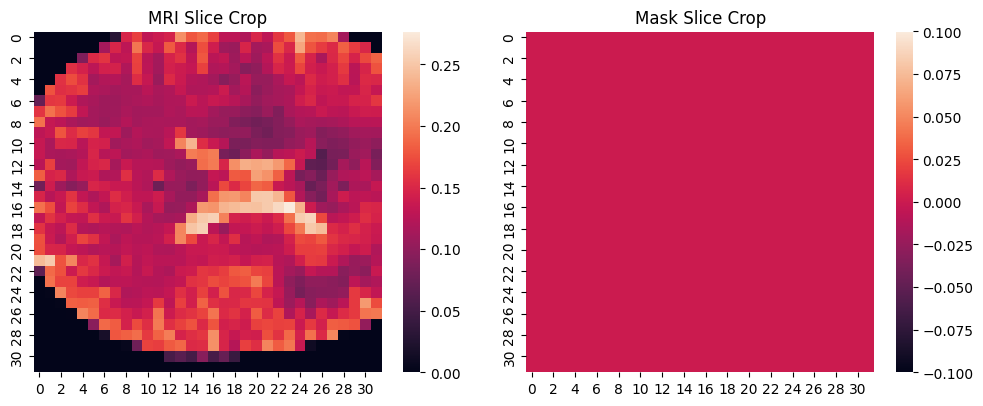

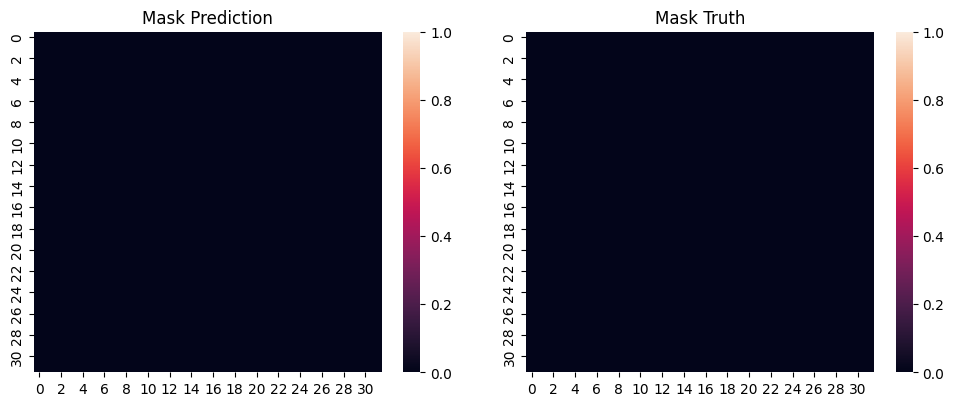

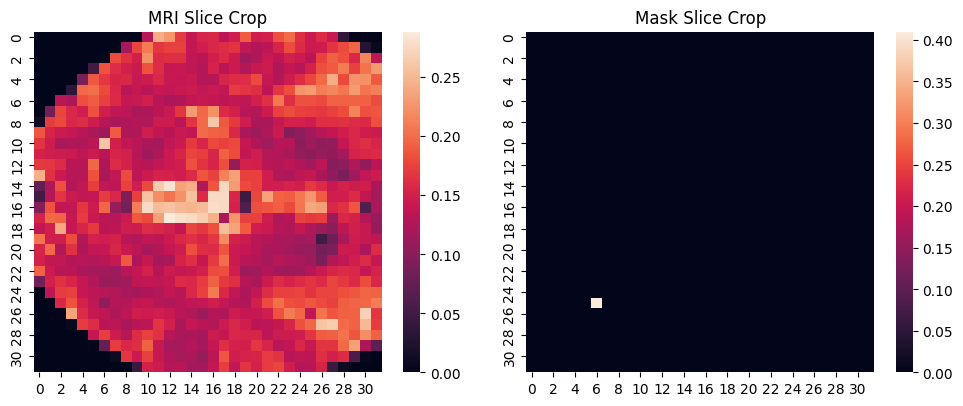

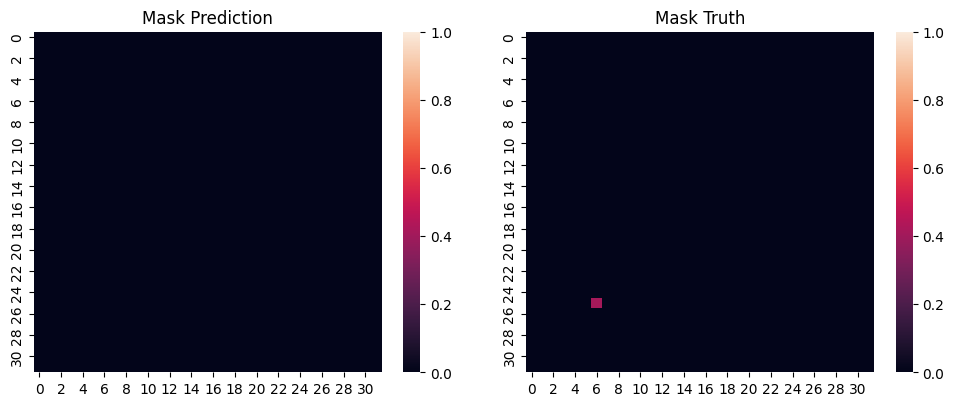

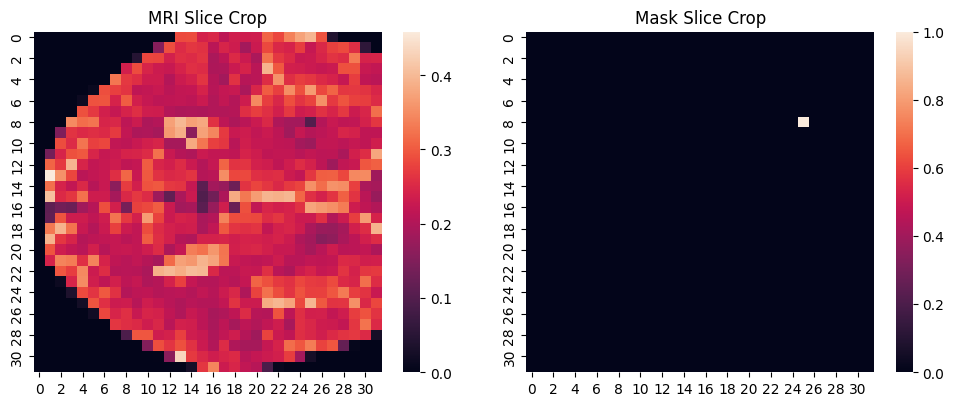

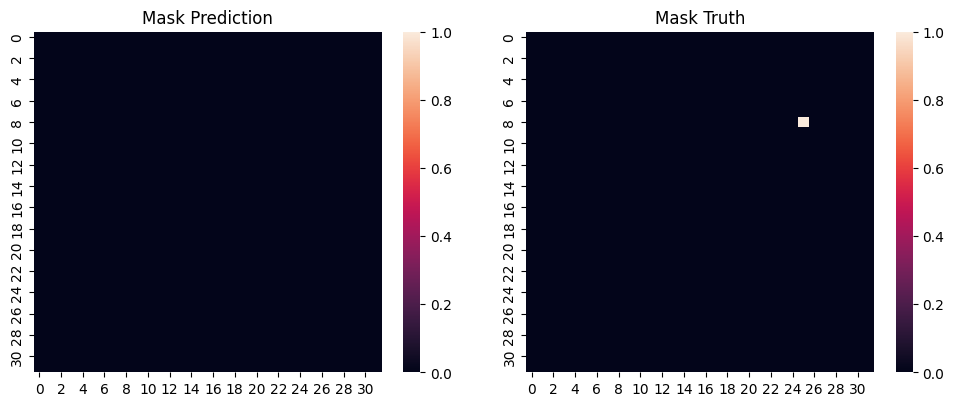

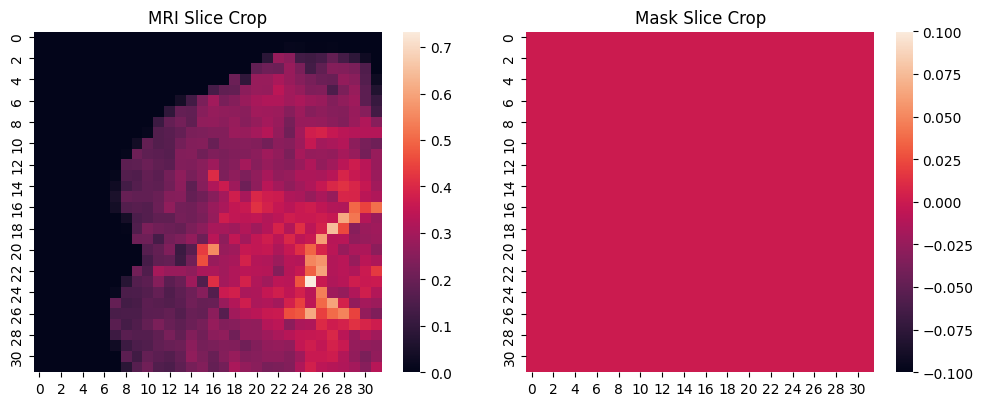

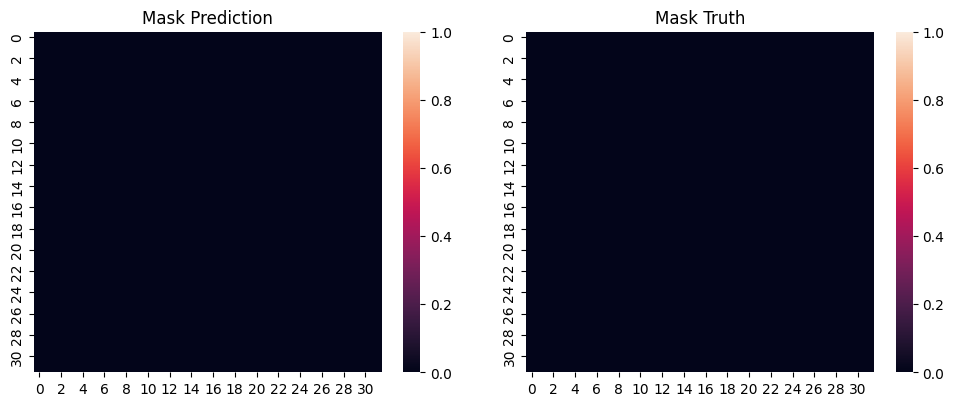

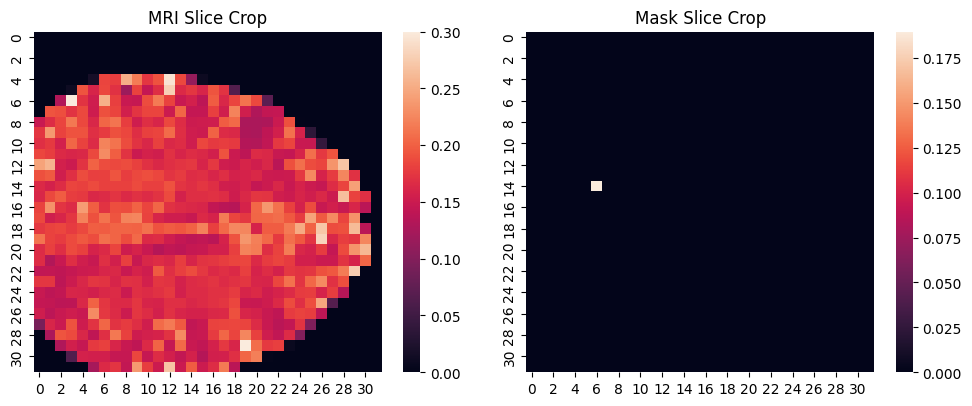

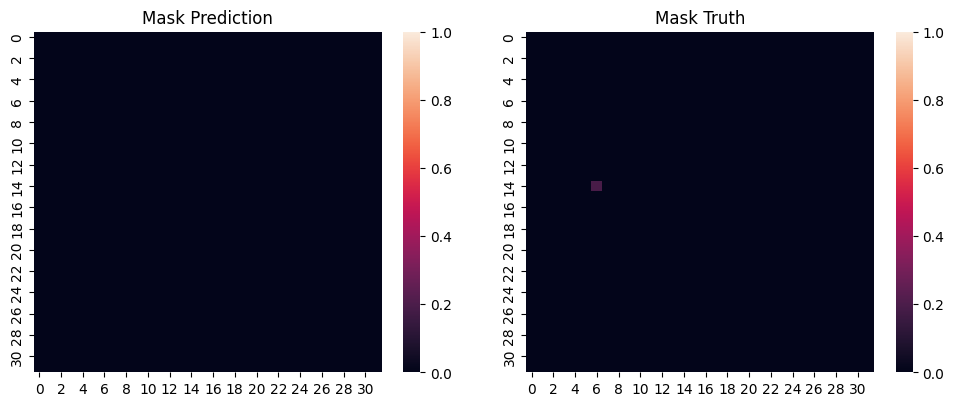

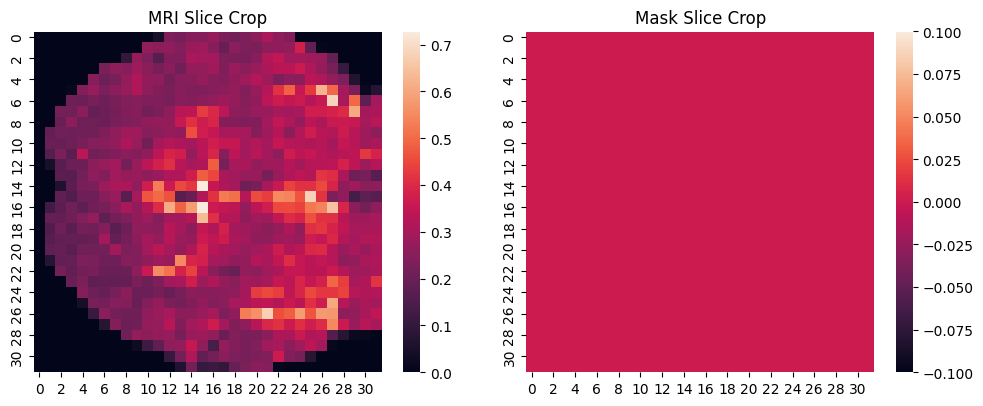

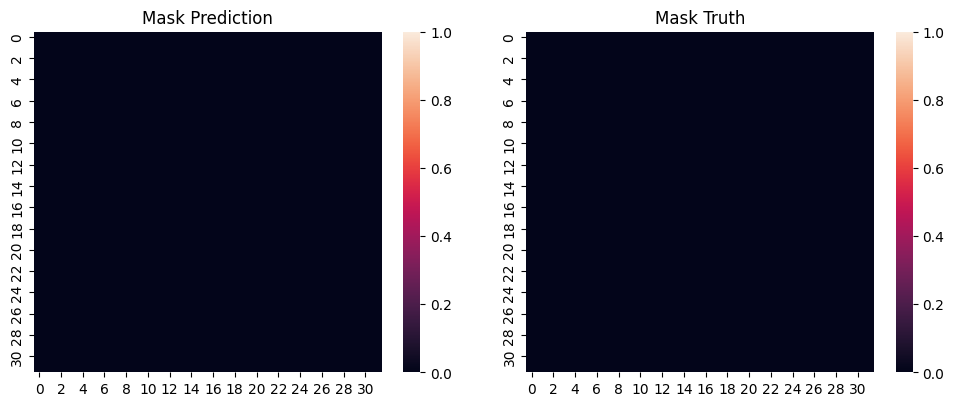

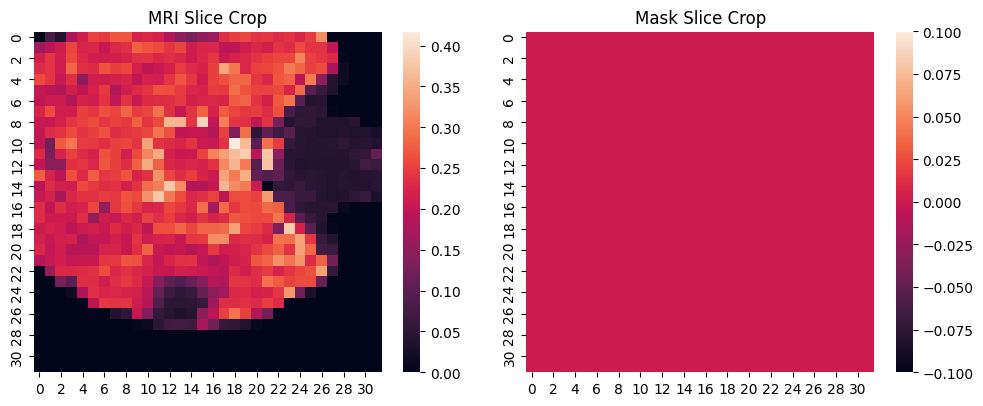

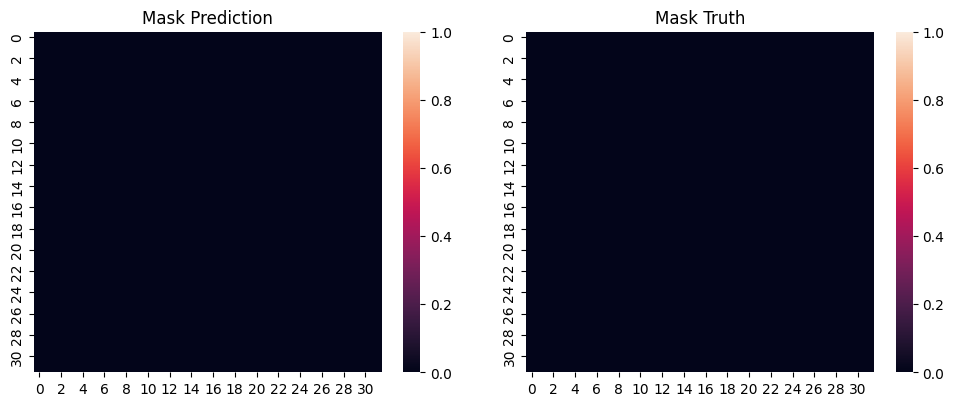

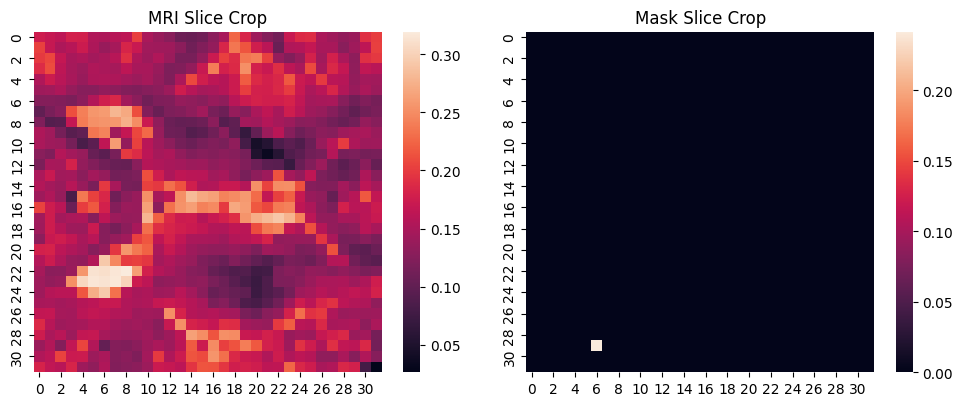

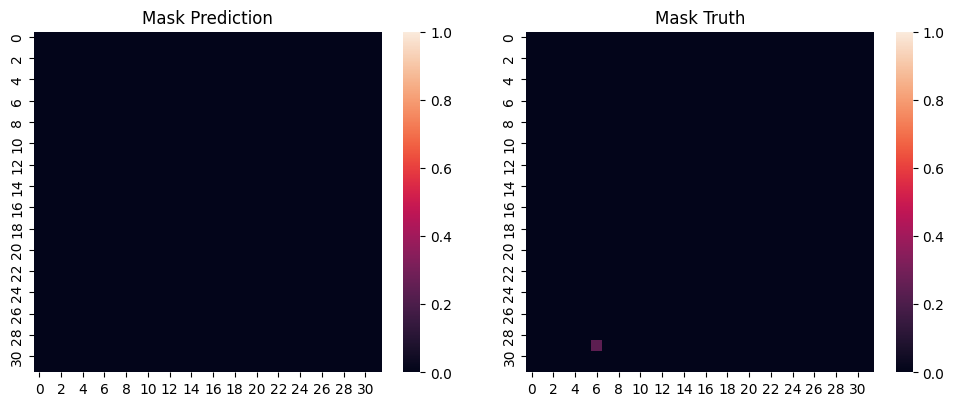

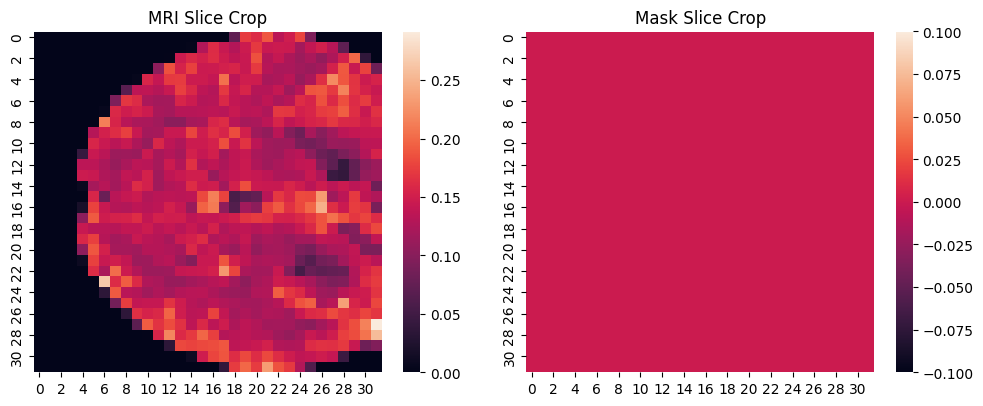

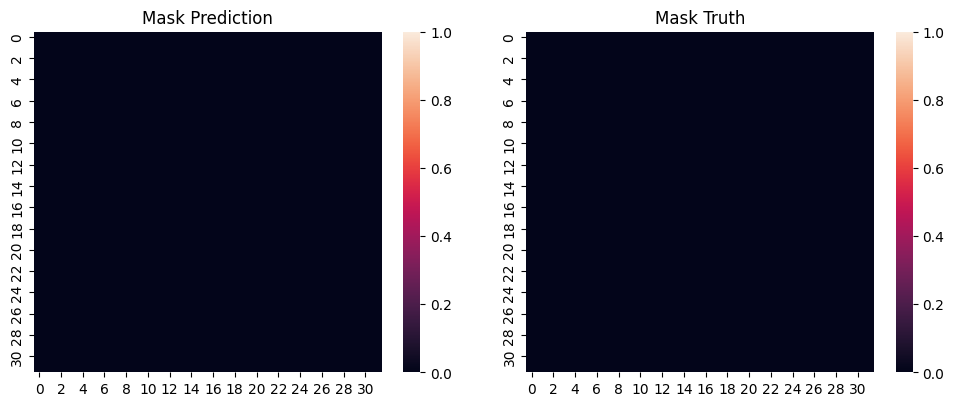

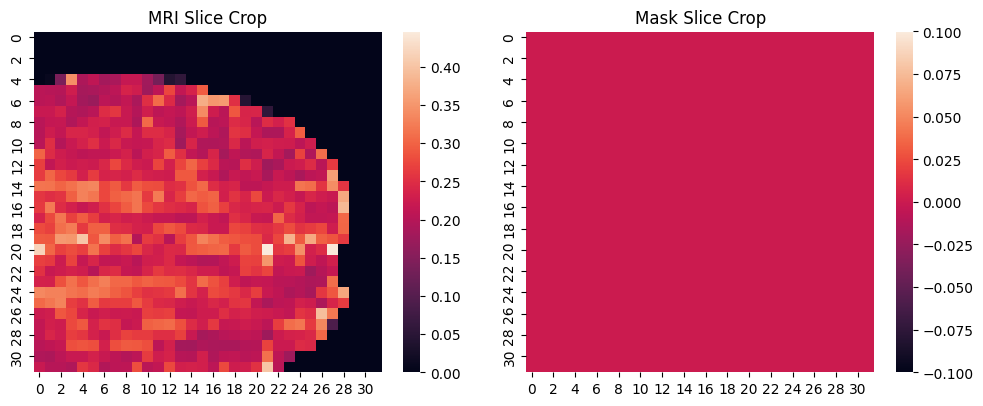

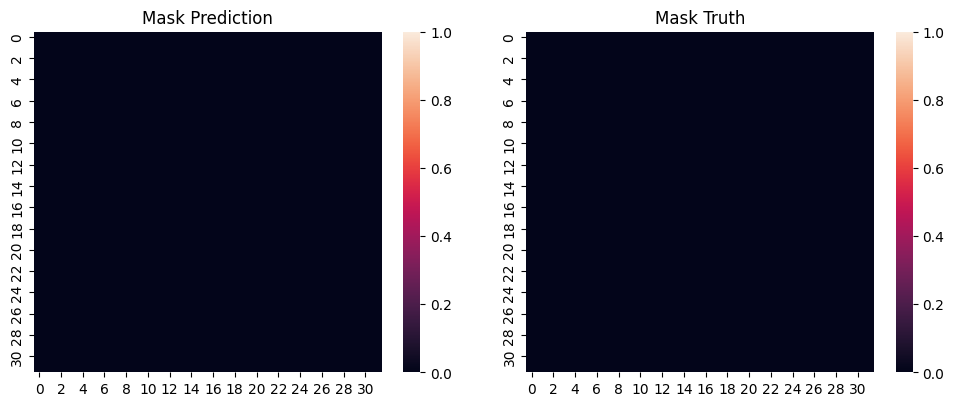

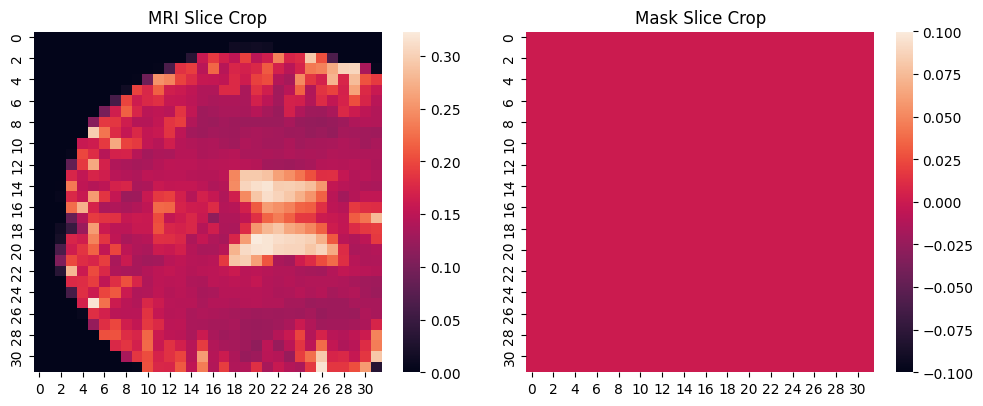

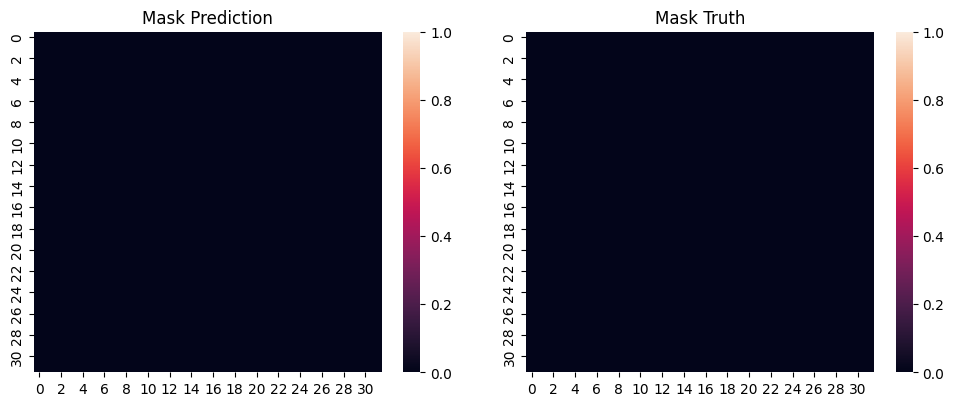

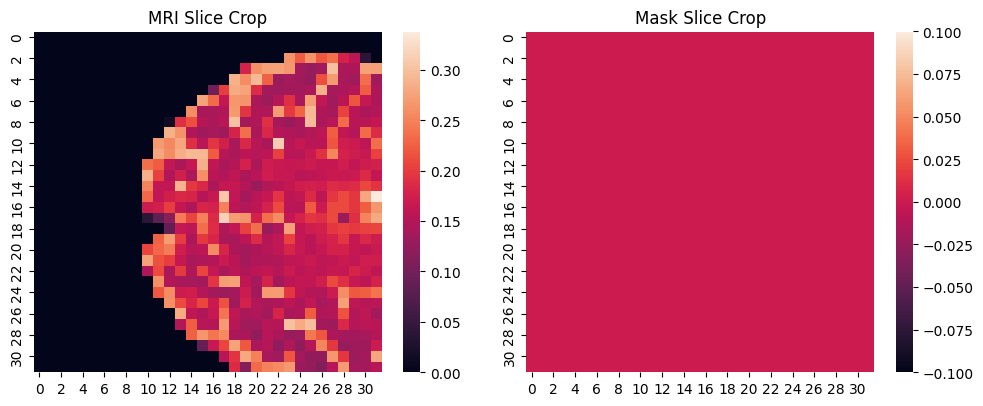

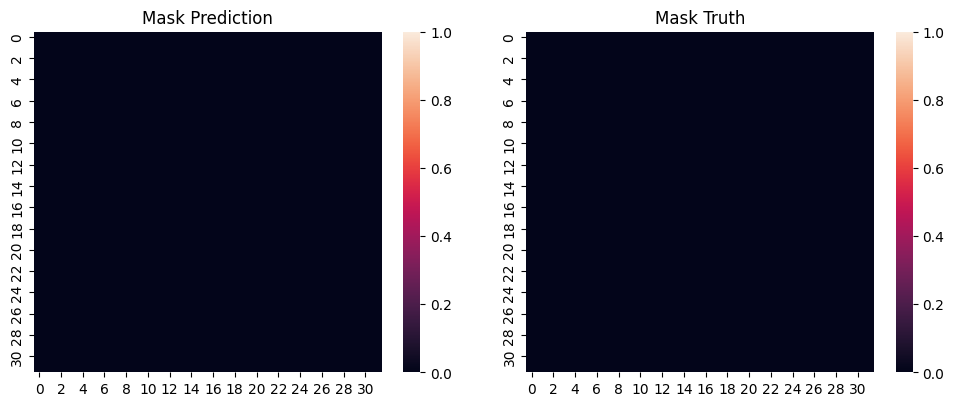

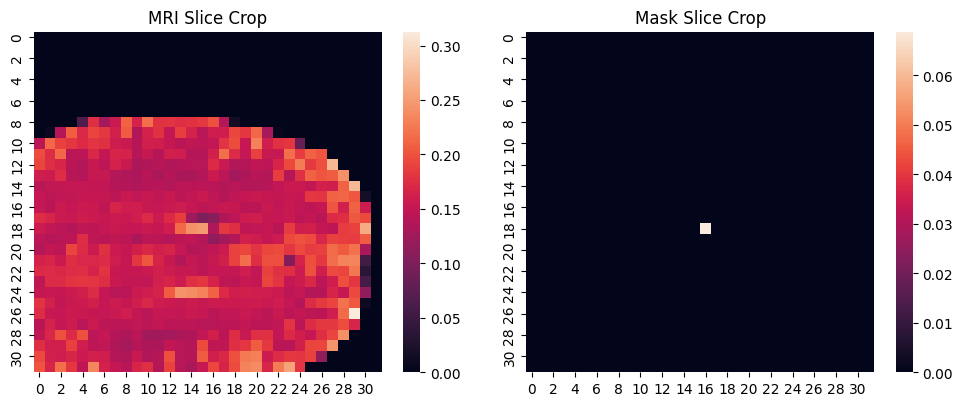

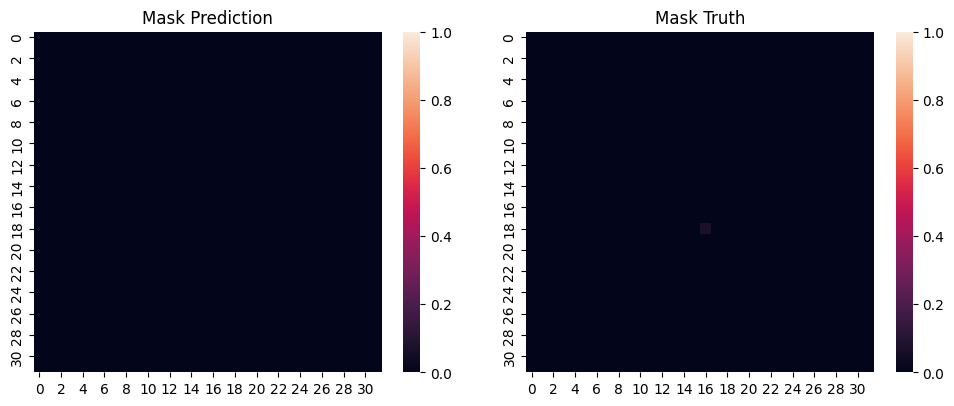

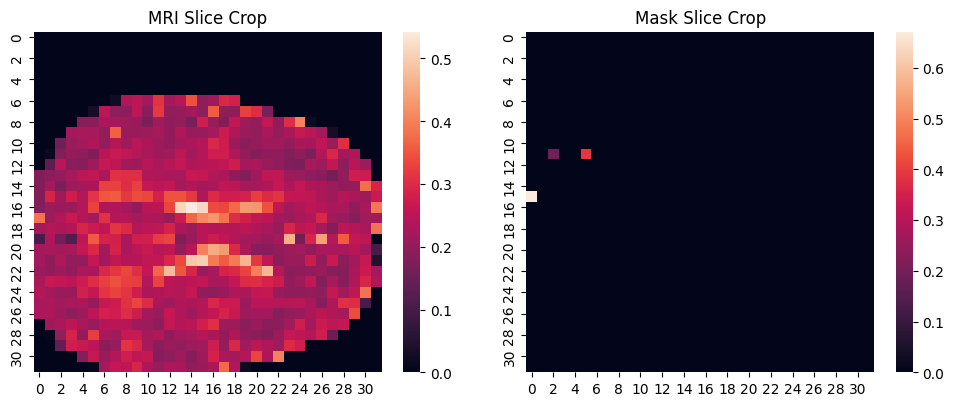

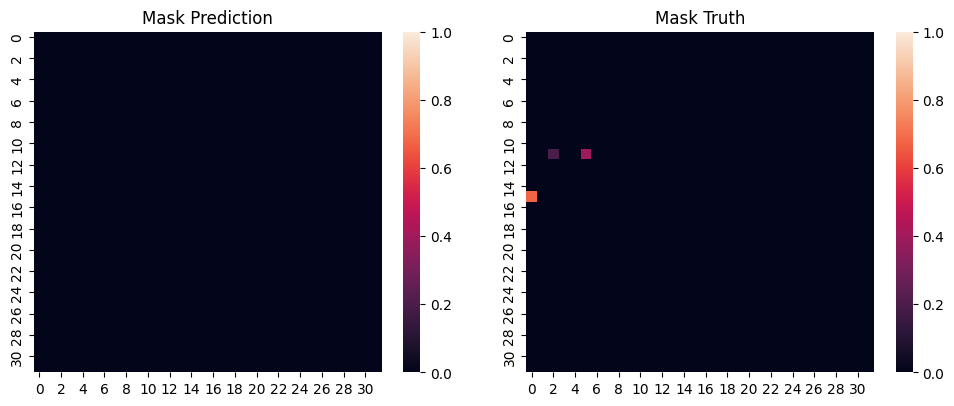

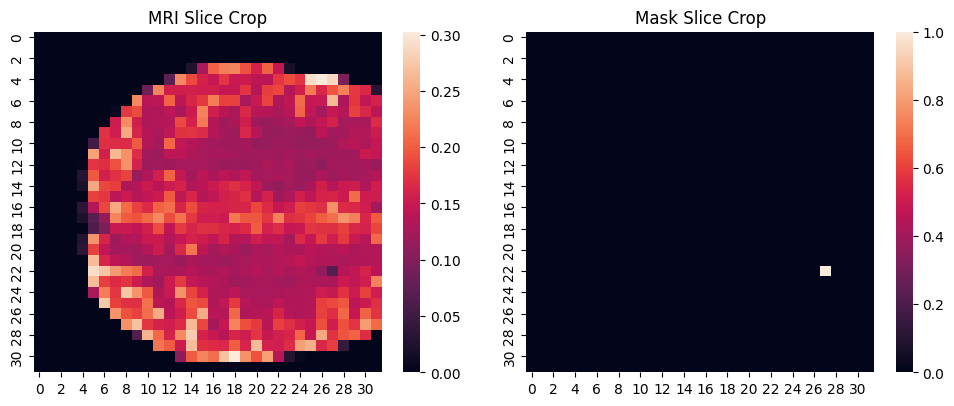

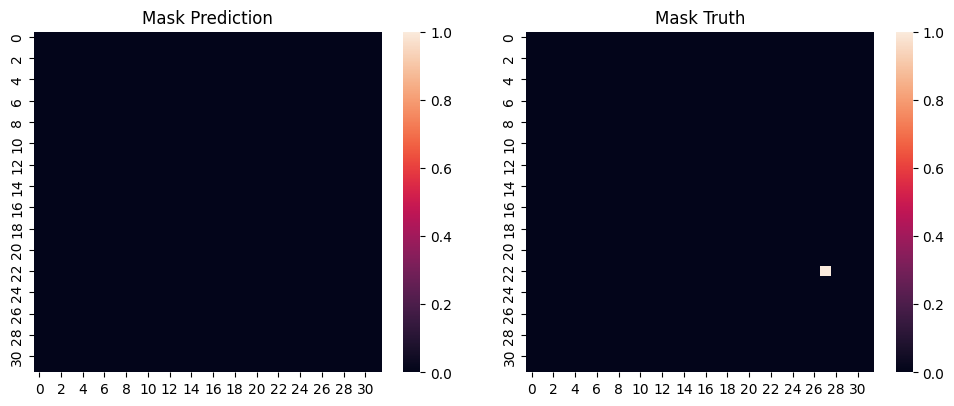

In [36]:
sample = next(iter(vit_test_dataloader))

for i in range(len(next(iter(vit_test_dataloader)))):
    vit_slices, vit_masks, vit_target, vit_case = sample[i]
    
    vit_slices = vit_slices.squeeze(1).float().to(device)
    vit_masks = vit_masks.float().to(device)
    
    vit_x, vit_t = stone(vit_slices, vit_masks, vit_target)
    
    f, a = plt.subplots(1, 2, figsize=(10, 4))

    f.tight_layout()
    ax1 = a.flat[0]
    ax2 = a.flat[1]
    ax1.set_title('MRI Slice Crop')
    ax2.set_title('Mask Slice Crop')
    sns.heatmap(vit_x[vit_target].squeeze(), ax=ax1)
    sns.heatmap(vit_t[vit_target].squeeze(), ax=ax2)

    vit_y = vit_fitter.model(vit_x.flatten(2).to(device), vit_target)
    vit_y = vit_y.view(patch_size, patch_size)
    
    f, a = plt.subplots(1, 2, figsize=(10, 4))

    f.tight_layout()
    ax1 = a.flat[0]
    ax2 = a.flat[1]
    ax1.set_title('Mask Prediction')
    ax2.set_title('Mask Truth')
    sns.heatmap((vit_y > 0.5).detach().cpu(), ax=ax1, vmax=1)
    sns.heatmap(vit_t[vit_target].squeeze(), ax=ax2, vmax=1)

# Log Progress


In [37]:
vit_tk.notes = '''
Global Context
'''

In [38]:
vit_tk()

,model,loaded_weights,stage1_weights,uses_resnet,only_cmb_slices,cohort1,cohort2,cohort3,optimizer,epochs,...,recall,f1,fpr,saved_weights,saved_thist,saved_vhist,model_hyperparams,logfile,device,notes
date,,,,,,,,,,,,,,,,,,,,,
2024-11-23 15:38:33.000323,ViT,None,fold\Nov_23_2024_104831\fold_5\rpn_fold5.pt,None,True,True,False,True,<class 'torch.optim.adam.Adam'>,50,...,0 0.0 1 0.0 2 0.0 3 0.0 4 0.0 N...,0 0.0 1 0.0 2 0.0 3 0.0 4 0.0 N...,0 0.0 1 0.0 2 0.0 3 0.0 4 0.0 N...,None,None,None,"{'d_model': 512, 'patch_size': 32, 'dim_ff': 1...",rpn_vit_Nov_23_2024_153833.log,cuda,\nGlobal Context\n


In [39]:
if os.path.exists('history/runs.csv'):
    print('Merging to old df')

    prev_df = pd.read_csv('history/runs.csv', index_col='date')
    merged = pd.concat([prev_df, vit_tk()])
    merged.to_csv('history/runs.csv')
else:
    print('Making new csv file')
    vit_tk().to_csv('history/runs.csv')

Merging to old df


C:\Users\araza\AppData\Local\Temp\ipykernel_26384\4021215468.py:5: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  merged = pd.concat([prev_df, vit_tk()])
